In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline

# Bring in the data

In [2]:
RawData = pd.read_csv('Lincoln.met', index_col= False, sep = '\t', names =['Year','Day','MinT','MaxT','Rain','Radn','Wind','vp'])
RawData.set_index(['Year','Day'],inplace=True,drop=False)
RawData.where(RawData>-90,np.nan,inplace=True)

## Calculate Potential Evapotranspiration

In [3]:
RawData.loc[:,'Temp'] = [(RawData.loc[x,'MinT']+RawData.loc[x,'MaxT'])/2 for x in RawData.index]
RawData.loc[:,'PET'] = [et.PenmanEO(RawData.loc[x,'Radn'],
                            RawData.loc[x,'Temp'],
                            RawData.loc[x,'Wind']/86.4,
                            RawData.loc[x,'vp']/10,
                            "total") for x in RawData.index]

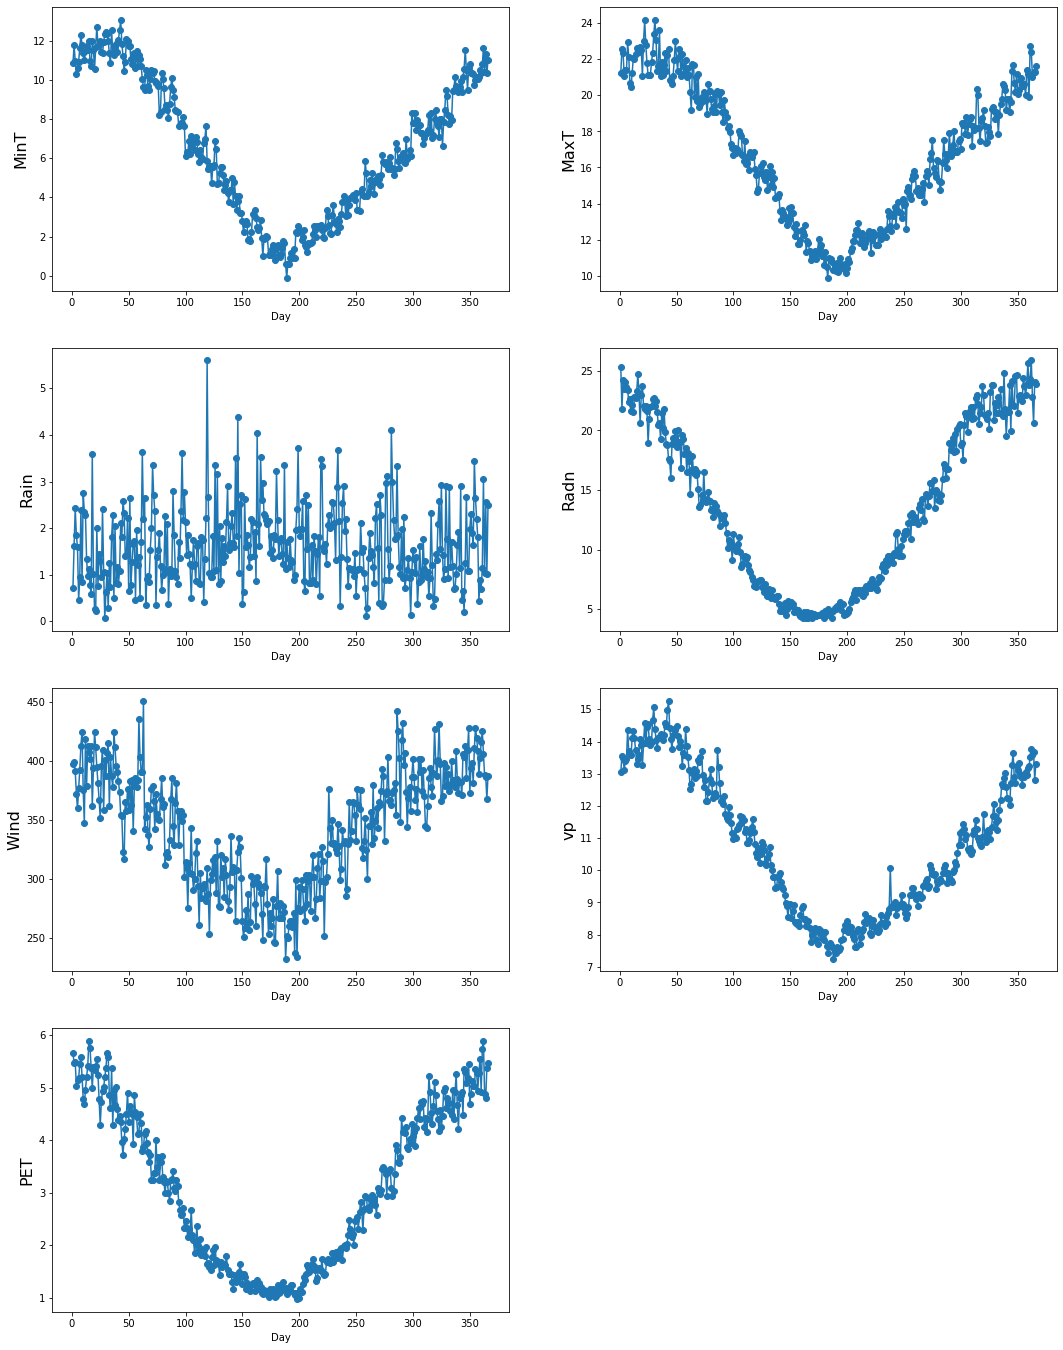

In [4]:
Fig = plt.figure(figsize = (18,24))
Position = 1
for x in [u'MinT', u'MaxT', u'Rain', u'Radn', u'Wind', u'vp','PET']:
    Fig.add_subplot(4,2,Position)
    Means = RawData.groupby(level='Day').mean()
    Means.loc[:,x].plot(marker='o')
    plt.ylabel(x,fontsize = 16)
    Position +=1

[Text(0, 0, '1-Jan'),
 Text(0, 0, '1-Mar'),
 Text(0, 0, '1-Jun'),
 Text(0, 0, '1-Sep'),
 Text(0, 0, '1-Jan')]

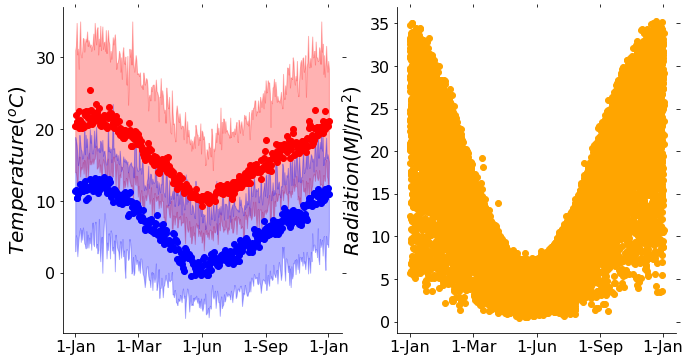

In [5]:
Fig = plt.figure(figsize = (11,6))
#for x in [u'MinT', u'MaxT', u'Rain', u'Radn', u'Wind', u'vp']:
Ax = Fig.add_subplot(1,2,1)
plt.tick_params(labelsize=16)
Ax.spines['right'].set_visible(False)
Ax.spines['top'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
plt.tick_params(axis='y', which='both', left='on',right='off', labelbottom='on')
Medians = RawData.loc[:,'MaxT'].groupby(level='Day').median()
#SEs = RawData.groupby(level='Day').std()
Upper = RawData.loc[:,'MaxT'].groupby(level='Day').max()
Lower = RawData.loc[:,'MaxT'].groupby(level='Day').min()
plt.fill_between(Medians.index,
                     Upper,
                     Lower,
                alpha = 0.3,color='r')
plt.plot(Medians,'o',color='r')
Medians = RawData.loc[:,'MinT'].groupby(level='Day').median()
#SEs = RawData.groupby(level='Day').std()
Upper = RawData.loc[:,'MinT'].groupby(level='Day').max()
Lower = RawData.loc[:,'MinT'].groupby(level='Day').min()
plt.fill_between(Medians.index,
                     Upper,
                     Lower,
                alpha = 0.3,color='b')
plt.plot(Medians,'o',color='b')
plt.ylabel(r'$Temperature (^oC)$',fontsize=20)
Ax.set_xticks([1,92,183,275,365])
Ax.set_xticklabels(['1-Jan','1-Mar','1-Jun','1-Sep','1-Jan'])
Ax = Fig.add_subplot(1,2,2)
plt.tick_params(labelsize=16)
Ax.spines['right'].set_visible(False)
Ax.spines['top'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
plt.tick_params(axis='y', which='both', left='on',right='off', labelbottom='on')
DayIndexed = RawData.copy()
DayIndexed.index = DayIndexed.index.droplevel('Year')
plt.plot(DayIndexed.index,DayIndexed.loc[:,'Radn'],'o',color='orange')
plt.ylabel(r'$Radiation (MJ/m^2)$',fontsize=20)
Ax.set_xticks([1,92,183,275,365])
Ax.set_xticklabels(['1-Jan','1-Mar','1-Jun','1-Sep','1-Jan'])

# Replace suspect data with -99, or

In [6]:
CleanData = RawData.copy()
CleanData.loc[:,'MinT'].where(CleanData.loc[:,'MinT']>-10,-99,inplace=True)
CleanData.loc[:,'MaxT'].where(CleanData.loc[:,'MaxT']<35,-99,inplace=True)
CleanData.loc[:,'Rain'].where(CleanData.loc[:,'Rain']<200,-99,inplace=True)
CleanData.loc[:,'Radn'].where(CleanData.loc[:,'Radn']<35,-99,inplace=True)
CleanData.loc[:,'Wind'].where(CleanData.loc[:,'Wind']<2000,-99,inplace=True)
CleanData.loc[:,'vp'].where(CleanData.loc[:,'vp']<30,-99,inplace=True)
CleanData.loc[:,'PET'].where(CleanData.loc[:,'PET']>0,-99,inplace=True)

# Replace suspect data with long term mean

In [7]:
for var in [u'MinT', u'MaxT', u'Rain', u'Radn', u'Wind', u'vp', u'PET']:
    for x in CleanData.index:
        Day = CleanData.loc[x,'Day']
        if CleanData.loc[x,var] == -99:
            CleanData.loc[x,var] = Means.loc[Day,var]

## Put in a Date column

In [8]:
for x in CleanData.index:
    OneDate = datetime.datetime(int(CleanData.loc[x,'Year']),1,1)
    JDayLessOne = int(CleanData.loc[x,'Day']-1)
    TodayDate = OneDate + datetime.timedelta(JDayLessOne)
    CleanData.loc[x,'Date'] = TodayDate

## Put CleanData onto a complete date index so any missing days are apparent

In [9]:
StartDate = CleanData.Date.min()
EndDate = CleanData.Date.max()
AllDates = pd.date_range(StartDate,EndDate)
CleanData.set_index('Date',drop=False,inplace=True)
CleanData = CleanData.loc[AllDates,:]

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

## Fill year and day columns for missing dates

In [ ]:
for x in CleanData.index:
    if np.isnan(CleanData.loc[x,'Year']):
        CleanData.loc[x,'Year'] = CleanData.loc[x,:].name.year
        CleanData.loc[x,'Day'] = CleanData.loc[x,:].name.dayofyear
        CleanData.loc[x,'Date'] = CleanData.loc[x,:].name

## Replace missing data with long term means

In [ ]:
for var in [u'MinT', u'MaxT', u'Rain', u'Radn', u'Wind', u'vp']:
    for x in CleanData.index:
        if np.isnan(CleanData.loc[x,var]):
            Day = CleanData.loc[x,'Day']
            CleanData.loc[x,var] = Means.loc[Day,var]

In [ ]:
CleanData.loc['2017-8-15']

In [ ]:
CleanData.to_csv('LincolnClean.met',sep='\t',index=False)

In [ ]:
Fig = plt.figure(figsize = (18,24))
Position = 1
for x in [u'MinT', u'MaxT', u'Rain', u'Radn', u'Wind', u'vp']:
    Fig.add_subplot(3,2,Position)
    CleanData.loc[:,x].plot()
    plt.ylabel(x,fontsize = 16)
    Position +=1

In [ ]:
DayIndexed = RawData.copy()
DayIndexed.index = DayIndexed.index.droplevel('Year')
plt.plot(DayIndexed.index,DayIndexed.loc[:,'PET'],'o')


In [ ]:
Means.PET.to_pickle('MeanPET.pkl')